# Task 4 Dimensionality Reduction (PCA)

In [9]:
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
plt.rcParams['figure.dpi'] = 120

# load design matrix from Task 3 
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'feature_engineer(task3)'))





from feature_engineer import run_full_pipeline

df = pd.read_csv('../student_success_survey.csv')
df = df[df["pillar"] != "Other"].copy()
design_df = run_full_pipeline(df)
TARGET = 'final_course_score'
y = design_df[TARGET]
X = design_df.drop(columns=[TARGET])
NUMERIC = X.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL = X.select_dtypes(exclude=[np.number]).columns.tolist()
pillar = df.loc[design_df.index, 'pillar']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
pillar_train = pillar.loc[X_train.index]
from sklearn.impute import SimpleImputer
num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, NUMERIC), ('cat', cat_pipe, CATEGORICAL)], remainder='drop')
X_train_np = pre.fit_transform(X_train)
X_test_np  = pre.transform(X_test)
print(f"\nPreprocessed design matrix — Train: {X_train_np.shape}, Test: {X_test_np.shape}")


Preprocessed design matrix — Train: (188, 26), Test: (48, 26)


[[ 4.95848363e-01 -1.40037431e-01  6.48467759e-01  1.92608566e-01
  -4.16068354e-01 -3.23688945e-02  1.97695475e-01 -5.53768848e-02
  -6.32086366e-02 -1.41963750e-02 -5.69133244e-03 -2.68533518e-02
  -1.49962942e-01  1.49962942e-01 -5.99561287e-02  5.99561287e-02
  -9.45879084e-04  1.32219009e-02 -7.13539913e-03 -2.22015764e-03
  -3.09371516e-02 -8.17096386e-03 -2.22151772e-03 -2.08797591e-02
   2.55712902e-02  3.37176371e-02]
 [-3.95497031e-01 -6.02961588e-01 -8.02579400e-02  6.19689761e-01
  -2.32010857e-01  3.36888084e-02 -1.31027513e-01  4.02356396e-02
   3.68438541e-02  1.61903135e-02  6.55449014e-03 -2.48559319e-03
   5.21428328e-02 -5.21428328e-02  2.24684511e-02 -2.24684511e-02
   2.91257875e-02 -1.41212943e-02 -6.65259327e-03 -3.50006668e-02
  -8.79403915e-04  3.65668803e-02  3.95937236e-02 -1.27723465e-04
   1.20820466e-03 -4.97129143e-02]
 [ 4.97504439e-01 -3.76050158e-01 -1.92052777e-01  2.36658456e-01
   6.79482967e-01 -4.04336278e-02  1.55820327e-01 -1.35325316e-02
  -4.4

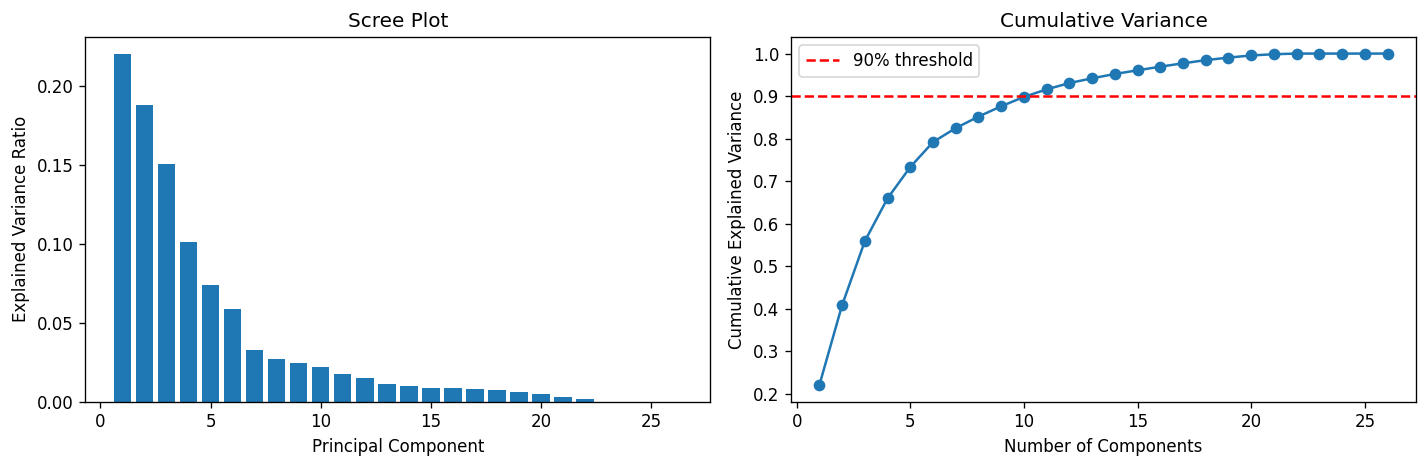

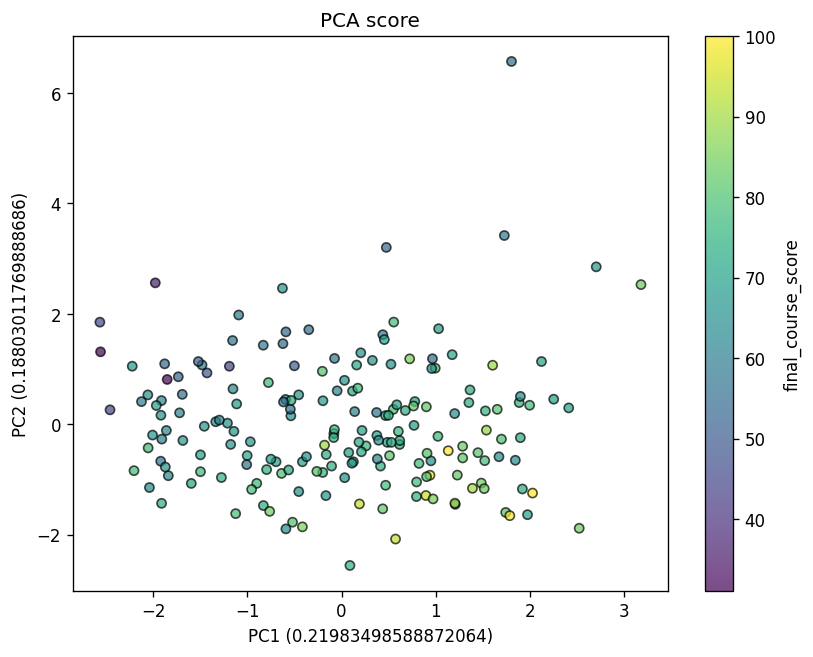

PC1 + PC2 explain 0.4078651035876075 of total variance


In [22]:
# fit on train to prevent leak
pca_full = PCA(random_state=SEED)
pca_full.fit(X_train_np)
print(pca_full.components_)
# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative) + 1), cumulative, 'o-')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
plt.tight_layout()
plt.show()

# scatter 
pca_2d = PCA(n_components=2, random_state=SEED)
Z = pca_2d.fit_transform(X_train_np)

plt.figure(figsize=(8, 6))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=y_train.values, alpha=0.7, s=30, edgecolors='k')
plt.colorbar(sc, label='final_course_score')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]})')
plt.title('PCA score')
plt.show()

print(f"PC1 + PC2 explain {pca_2d.explained_variance_ratio_.sum()} of total variance")

### Do students cluster?
No clear obvious clusters in the PCA. Students are spread out continuously rather than forming distinct groups. When colored by `final_course_score`, high and low performers are mixed. This suggests the relationship between features and performance is not captured by the top 2 principal components alone.

### What PCA does not tell us

1. Non-linear structure: PCA is linear, complex non-linear relationships cannot be seen. Use t-SNE or UMAP for that.
2. Predictive relevance: The highest variance direction may capture noise for predicting final_course_score.
3. The class separation: PCA does not optimise for separating groups
